In [1]:
import tensorflow as tf
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
#tf.config.run_functions_eagerly(True)

In [2]:
#setting data directory

Datadirectory = "E:/Dataset/Pneumonia/binary/"

Classes = ["NORMAL","PNEUMONIA"]

img_size =224

# Data Preprocessing

In [3]:
#Converting all training data to array with labels

training_Data = [] 

def create_training_Data():
    
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category)  #label 0,1 for classes

        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                
                clahe = cv2.createCLAHE(clipLimit=5) #applying CLAHE for contrast
                final_img = clahe.apply(img_array) 
                
                new_array = cv2.resize(final_img, (img_size,img_size))
                training_Data.append([new_array, class_num])
            except Exception as e:
                pass 

In [4]:
#creating training data

create_training_Data()

In [5]:
#shuffling data

import random

random.shuffle(training_Data)

In [6]:
#Splitting features and labels and converting features to numpy array

X = []
Y = []

for features,labels in training_Data:
    
    X.append(features)
    Y.append(labels)
    
print(len(X))
X = np.array(X).reshape(-1,img_size,img_size,1)
Y = np.array(Y)

5856


In [7]:
print(X.shape)
print(Y.shape)

(5856, 224, 224, 1)
(5856,)


In [8]:
#normalizing data

X = X/255.0

In [9]:
#saving data in .npy files

np.save('data', X)
np.save('label', Y)

# Explorative Data Analysis

In [10]:
#X = np.load('data.npy')
Y = np.load('label.npy')

In [11]:
unique, counts = np.unique(Y, return_counts=True)
LabelCounts = dict(zip(unique, counts))

for key, value in LabelCounts.items():
    if(key==0):
        print(key, '(Normal) : ', value)
    
    else:
        print(key, '(Pneumonia) : ', value)


0 (Normal) :  1583
1 (Pneumonia) :  4273


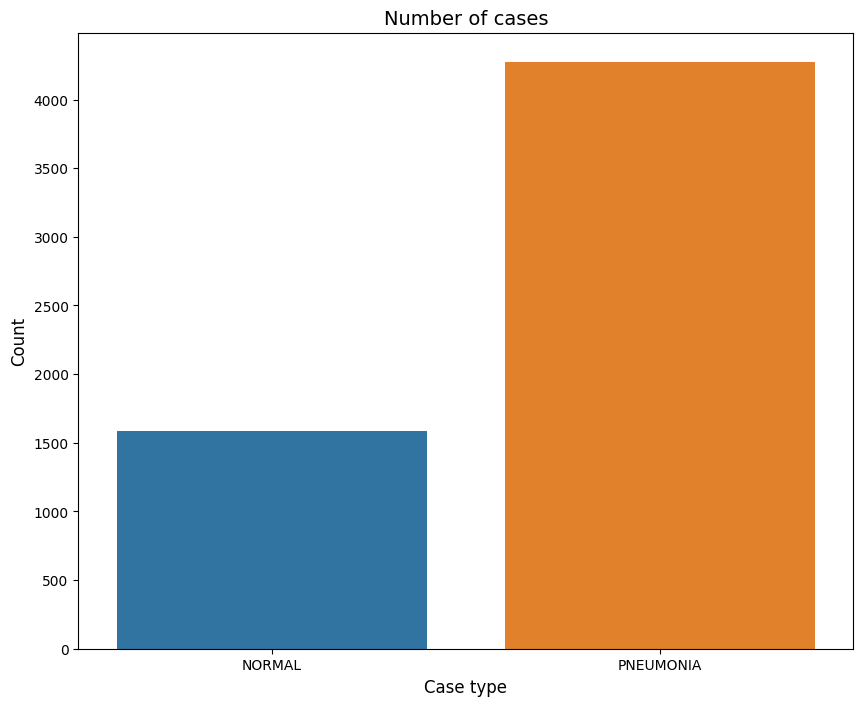

In [12]:
plt.figure(figsize=(10,8))
sns.barplot(x=unique, y= counts)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(unique)), ['NORMAL', 'PNEUMONIA'])
plt.show()

# Data Splitting & Augmentation

In [14]:
#X = np.load('data.npy')
#Y = np.load('label.npy')

In [13]:
# Separate the test data
X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

# Split the remaining data to train and validation
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, shuffle=True)

In [26]:
np.save('tdata', X_test)
np.save('tlabel', Y_test)

In [14]:
datagen = ImageDataGenerator(
        shear_range=0.15, #randomly change images angle of slant
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

# Model Creation


In [15]:
# initialize the initial learning rate, number of epochs, batch size
INIT_LR = 0.0001
EPOCHS = 20
BS = 32

In [16]:
#Model Layers

model = Sequential()
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (224,224,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(512 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(64 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1 , activation = 'sigmoid'))

In [17]:
#Model Compiling
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer = opt , loss = 'binary_crossentropy' , metrics = ['accuracy'])


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     2

In [19]:
#Decrease lr when model converges 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=INIT_LR)

In [20]:
#Model Training 
H = model.fit(datagen.flow(X_train,Y_train, batch_size = BS) ,
                    epochs = EPOCHS , validation_data = datagen.flow(X_val, Y_val) ,
                    callbacks = [learning_rate_reduction])

Epoch 1/20
118/118 [==============================] - 21s 130ms/step - loss: 0.4287 - accuracy: 0.8102 - val_loss: 0.6066 - val_accuracy: 0.7289 - lr: 1.0000e-04
Epoch 2/20
118/118 [==============================] - 15s 125ms/step - loss: 0.2865 - accuracy: 0.8804 - val_loss: 1.0263 - val_accuracy: 0.7289 - lr: 1.0000e-04
Epoch 3/20
118/118 [==============================] - 15s 129ms/step - loss: 0.2576 - accuracy: 0.8973 - val_loss: 2.2217 - val_accuracy: 0.7289 - lr: 1.0000e-04
Epoch 4/20
118/118 [==============================] - 16s 132ms/step - loss: 0.2451 - accuracy: 0.9007 - val_loss: 2.2632 - val_accuracy: 0.7289 - lr: 1.0000e-04
Epoch 5/20
118/118 [==============================] - 16s 134ms/step - loss: 0.2202 - accuracy: 0.9223 - val_loss: 1.0514 - val_accuracy: 0.7289 - lr: 1.0000e-04
Epoch 6/20
118/118 [==============================] - 16s 134ms/step - loss: 0.2121 - accuracy: 0.9157 - val_loss: 0.4771 - val_accuracy: 0.7823 - lr: 1.0000e-04
Epoch 7/20
118/118 [========

In [21]:
#saving the model

model.save('Model_Binary.h5')

# Result Visualization 


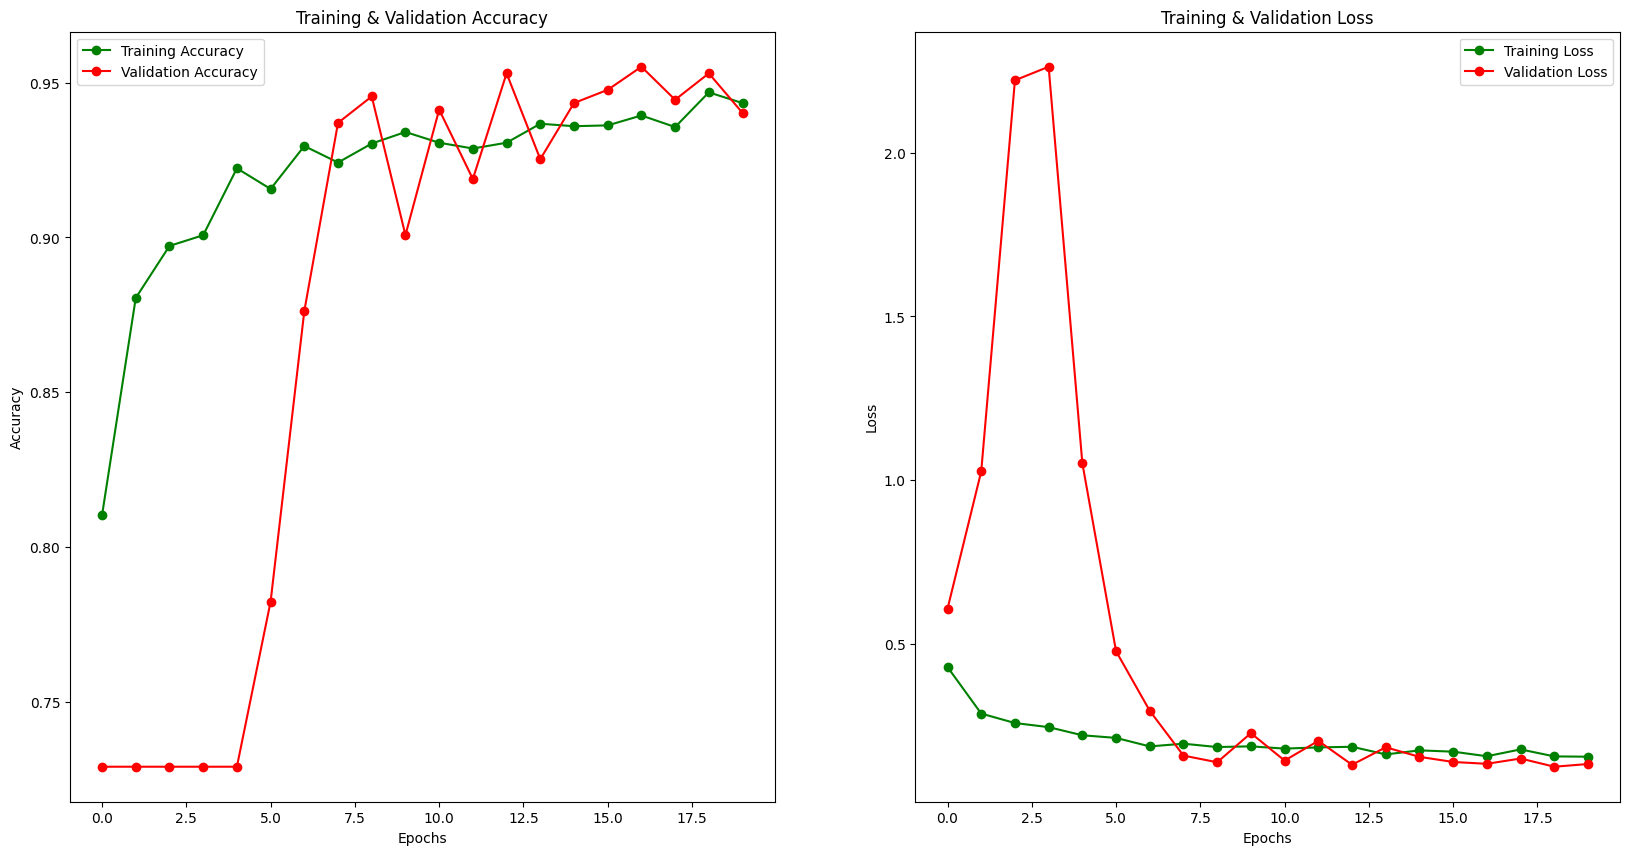

In [22]:
epochs = [i for i in range(EPOCHS)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

train_acc = H.history['accuracy']
train_loss = H.history['loss']
val_acc = H.history['val_accuracy']
val_loss = H.history['val_loss']


ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

# Model Evaluation

In [27]:
tfeature = np.load('tdata.npy')
tlabel = np.load('tlabel.npy')

In [28]:
new_model = tf.keras.models.load_model("Model_Binary.h5")

In [29]:
new_model.evaluate(tfeature,tlabel, verbose = 0)

[0.2881547212600708, 0.8694539070129395]

In [30]:
predIdxs = (new_model.predict(tfeature) > 0.5).astype("int32")

37/37 [==============================] - 1s 23ms/step


In [31]:
print(classification_report(tlabel, predIdxs))

              precision    recall  f1-score   support

           0       0.66      1.00      0.80       303
           1       1.00      0.82      0.90       869

    accuracy                           0.87      1172
   macro avg       0.83      0.91      0.85      1172
weighted avg       0.91      0.87      0.88      1172



Text(95.72222222222221, 0.5, 'Actual')

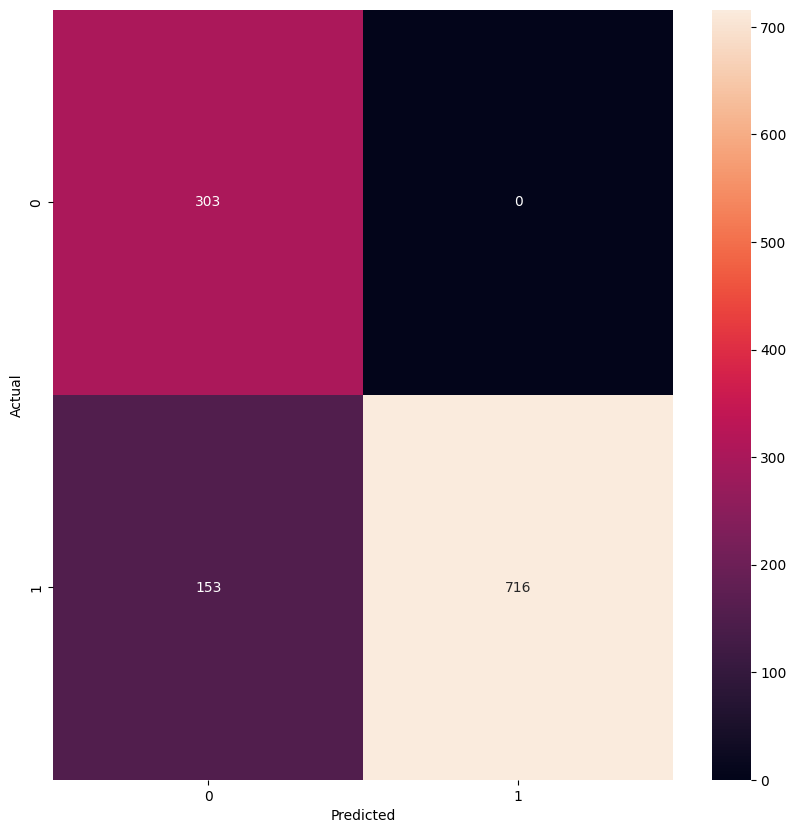

In [32]:
plt.figure(figsize=(10,10))
sns.heatmap(tf.math.confusion_matrix(tlabel, predIdxs), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')